In [6]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import networkx as nx
import numpy.fft
import random
import bct
import math
import statistics

from source.utils.io_utils import readMRIFile, load_txt
from source.utils.matrix_utils import (
    createCorrelationMatrix,
    findThreshold,
    binarize,
    randomizeCorrelationMatrix,
    null_covariance
)
from source.utils.phase_utils import (
    phaseScramble1,
    calculate_small_worldness
)
from source.phase_and_correlation_scramble import (
    run_small_worldness_analysis
)
from source.utils.plot_utils import plot_timeseries, plot_correlation_matrix

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
#Variables that will not change and used throughout the code
file_path = '/Users/nivaranavat/BrainConnectivity_ResearchProject/Data/SAL_01/roi'

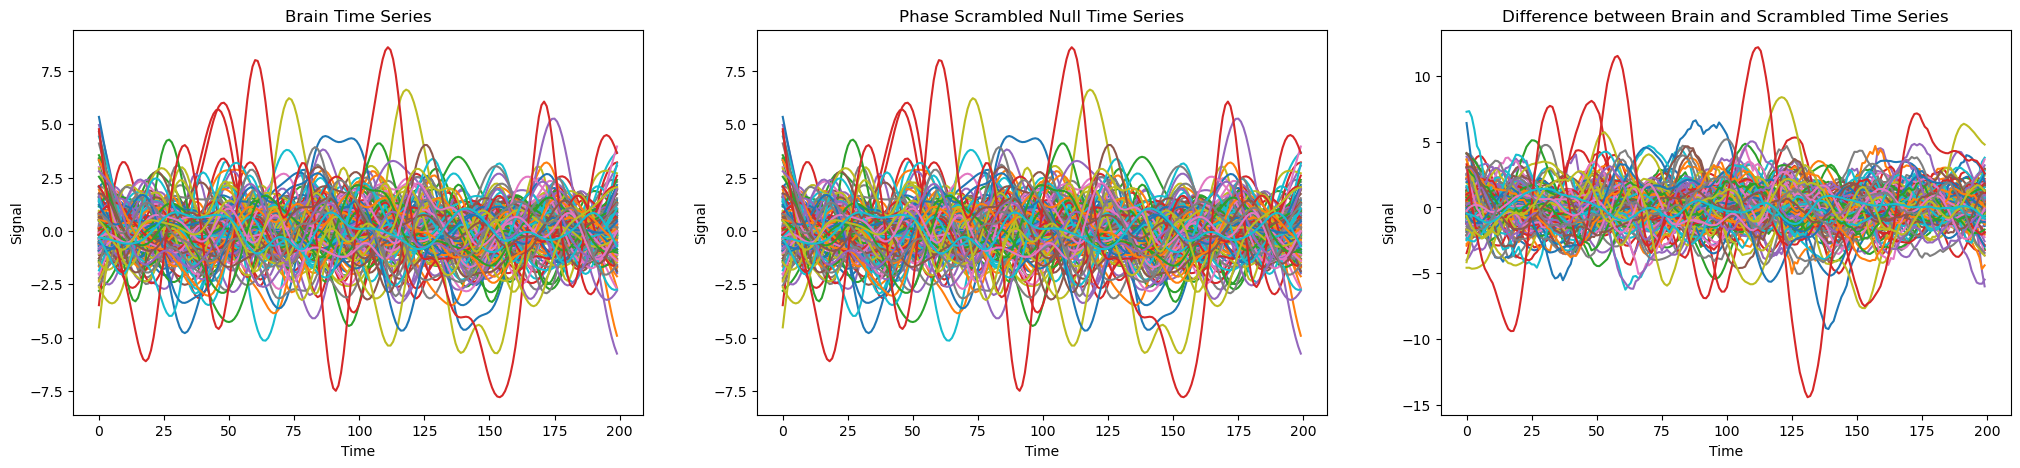

In [9]:
#the main function that will run the meat of our code

#read the data from our folder and generate a visualization plot
#using the observed brain data phase scramble the ROI's to create our null

#create the figure to add our plots
fig, ax = plt.subplots(nrows=1 , ncols=3, figsize=(25, 5))


#read the MRI data first and plot
x ,roi_timeseries = readMRIFile(file_path,200)
plot_timeseries(roi_timeseries, x, title="Brain Time Series", show=False, ax=ax[0])
    
#scramble the phases and plot that
null_timeseries = []
#doing the fourier transform on each 
#doing the fourier transform on each 
for i in range(len(roi_timeseries)):
    series = phaseScramble1(roi_timeseries[i])
    null_timeseries.append(series)
plot_timeseries(roi_timeseries, x, title="Phase Scrambled Null Time Series", show=False, ax=ax[1])


#plot the difference between the two actual brain and the randomized brain
plot_timeseries((roi_timeseries - null_timeseries).real, x, title="Difference between Brain and Scrambled Time Series", show=False, ax=ax[2])

#save the plots and display
plt.savefig("./results/PhaseScrambledPloitsTimeSeries Plots.png")
plt.show()

/Users/nivaranavat/miniconda/envs/brain-env/lib/python3.10/site-packages/pandas/core/internals/managers.py:1688: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(blk.values, dtype=dtype, copy=copy)


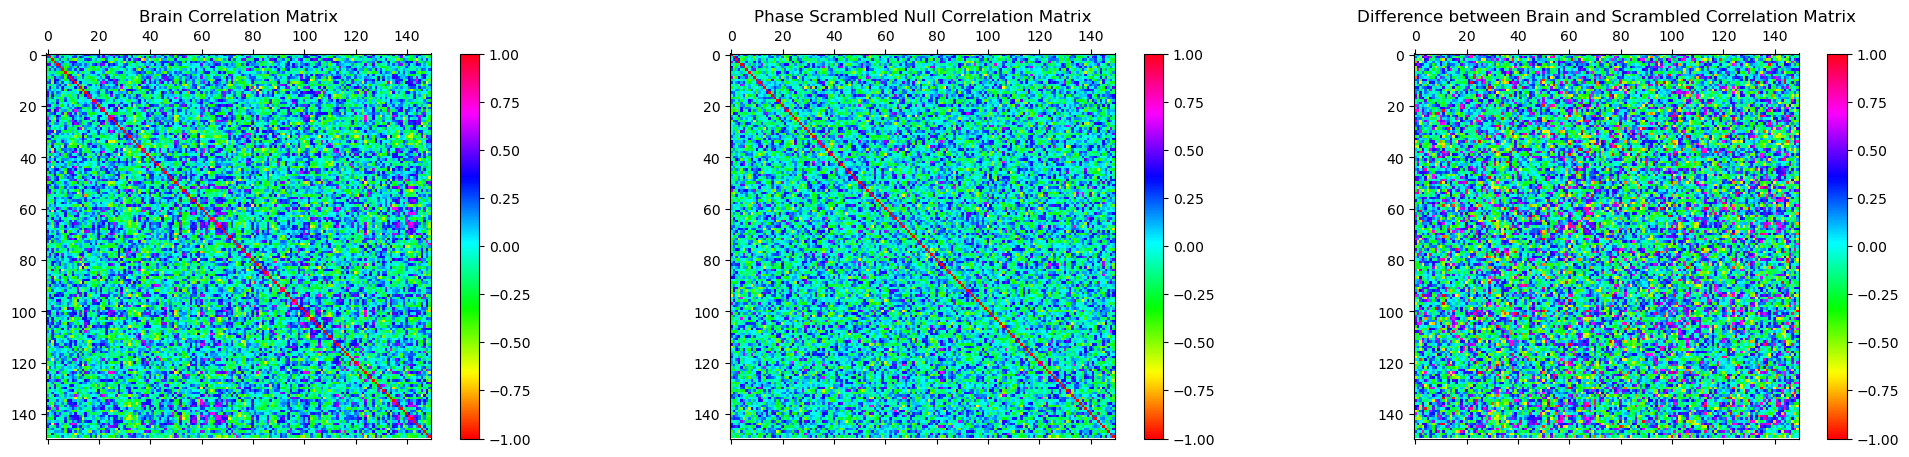

In [10]:
#find the correlation matrix and plot for the observed brain network and the phase scrambled null created

import matplotlib.colors

cmap = "hsv"
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)


#plot out the correlation matrices
fig, ax = plt.subplots(nrows=1 , ncols=3, figsize=(25, 5))

#create the correlation matrix for brain and null
brain_correlationMatrix = createCorrelationMatrix(roi_timeseries,"pearson")
brain_correlationMatrix = brain_correlationMatrix - np.identity(150)
null1_correlationMatrix = createCorrelationMatrix(null_timeseries,"pearson")
null1_correlationMatrix = null1_correlationMatrix - np.identity(150)

#plot the brain's correlation matrix
plot_correlation_matrix(brain_correlationMatrix-np.identity(150), title="Brain Correlation Matrix", show=False, ax=ax[0], cmap=cmap, norm=norm)

#plot the null's correlation matrix
plot_correlation_matrix(null1_correlationMatrix-np.identity(150), title="Phase Scrambled Null Correlation Matrix", show=False, ax=ax[1], cmap=cmap, norm=norm)
              
#plot the difference between brain and null correlation matrix 
plot_correlation_matrix((brain_correlationMatrix-np.identity(150))-(null1_correlationMatrix-np.identity(150)), title="Difference between Brain and Scrambled Correlation Matrix", show=False, ax=ax[2], cmap=cmap, norm=norm)            


#save the plots and display  
plt.savefig("./results/PhaseScramblingPlots/Correlation Matrix Plots.png")
plt.show()


Brain threshold:  0.2987099078999725
Null1 threshold:  0.25940692736897963


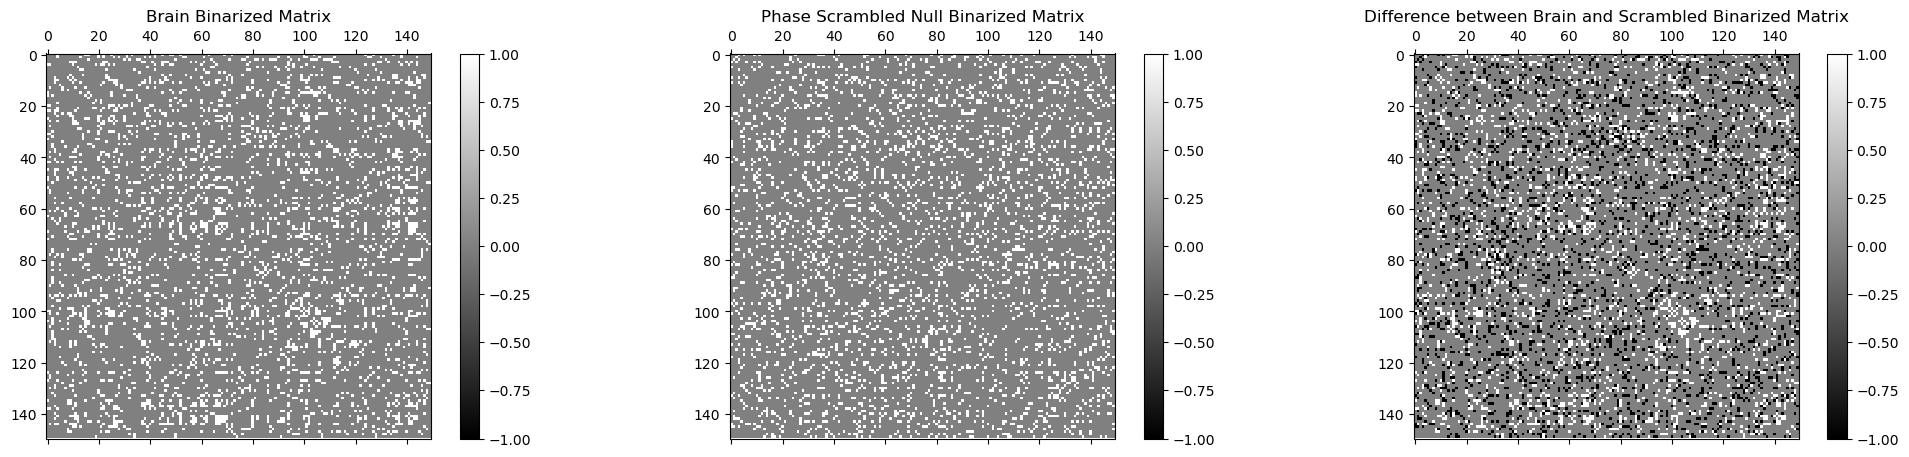

In [11]:
#binarize the networks using 15% density
#binarize the networks using 15% density

cmap = "binary_r"
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)


#plot out the binarized matrices based on the correlation matrix and the threshold
fig, ax = plt.subplots(nrows=1 , ncols=3, figsize=(25, 5))

#binarize both brain and null correlation matrix
brain_threshold = findThreshold(brain_correlationMatrix,0.15)
null1_threshold = findThreshold(null1_correlationMatrix,0.15)
brain_binaryMatrix= binarize(brain_correlationMatrix,brain_threshold)
null1_binaryMatrix = binarize(null1_correlationMatrix,null1_threshold)

print("Brain threshold: ", brain_threshold)
print("Null1 threshold: ", null1_threshold)

#plot the brain's binarized matrix
plot_correlation_matrix(brain_binaryMatrix, title="Brain Binarized Matrix", show=False, ax=ax[0], cmap=cmap, norm=norm)

#plot the null's graph
plot_correlation_matrix(null1_binaryMatrix, title="Phase Scrambled Null Binarized Matrix", show=False, ax=ax[1], cmap=cmap, norm=norm)
            
#plot out the difference
plot_correlation_matrix((brain_binaryMatrix)-(null1_binaryMatrix), title="Difference between Brain and Scrambled Binarized Matrix", show=False, ax=ax[2], cmap=cmap, norm=norm)
        
    
#save the plot and display it
plt.savefig("./results/PhaseScramblingPlots/Binarized Matrix Plots.png")
plt.show()



In [12]:

#next step is to check the ratios of coefficient and path length between our created null and the observed brain

#calculate our clustering coefficient, path length, and small worldness
#values should be >1 or ~1

small_worldness, normalized_ccoef, normalized_path_length = calculate_small_worldness(brain_binaryMatrix, null1_binaryMatrix)

print()
print("Ratios:")
print("Brain/Null1 path length: ", normalized_path_length)
print("Brain/Null1 clustering coefficient: " , normalized_ccoef)
print("Brain small worldness with null1: ", small_worldness)


Ratios:
Brain/Null1 path length:  1.036680990563948
Brain/Null1 clustering coefficient:  1.1012787027658393
Brain small worldness with null1:  1.0623120446790004


/Users/nivaranavat/miniconda/envs/brain-env/lib/python3.10/site-packages/pandas/core/internals/managers.py:1688: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(blk.values, dtype=dtype, copy=copy)


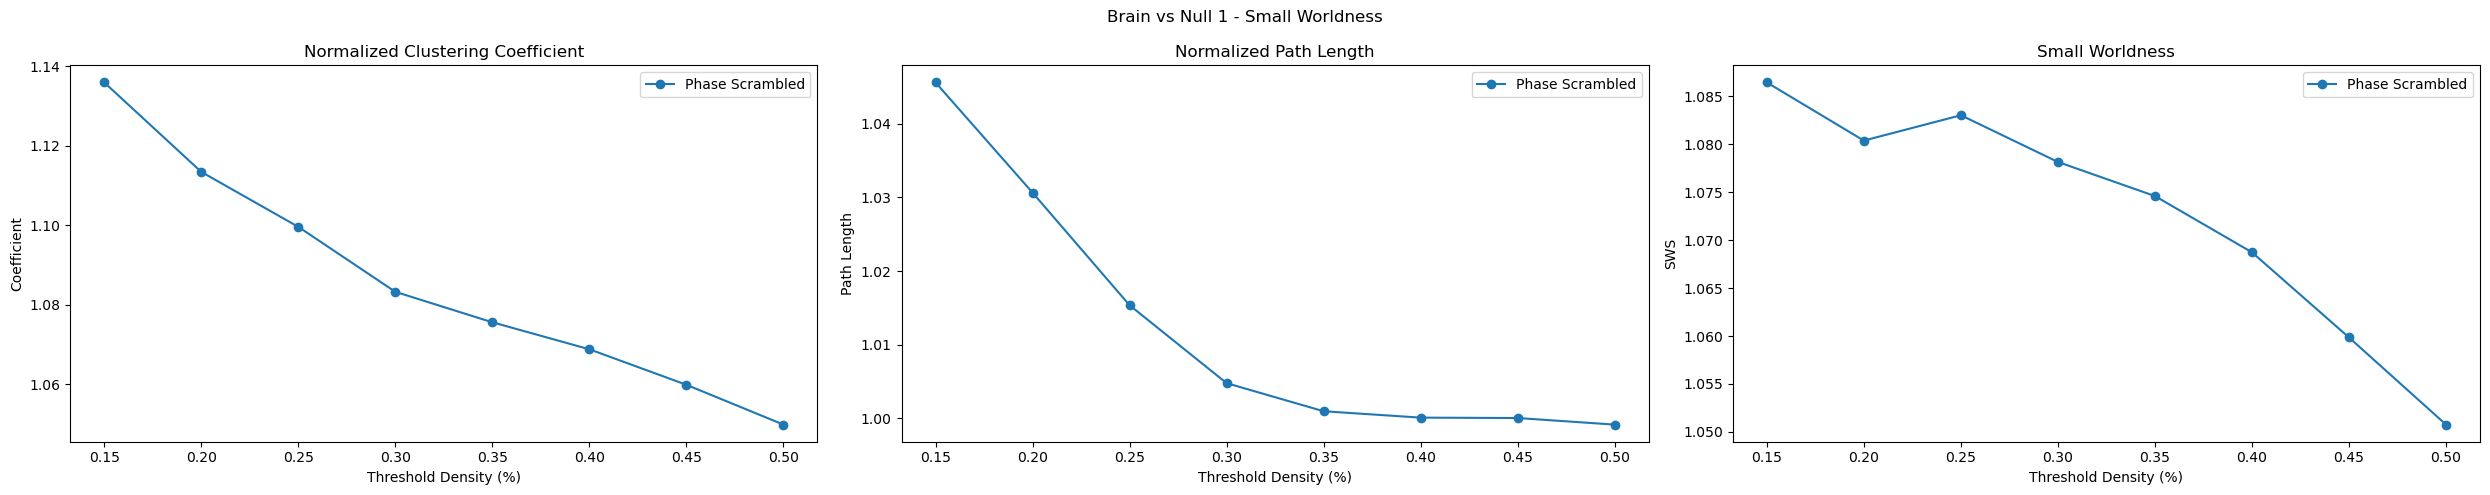

In [13]:
#try the range of 10% to 50% threshold density for binarizing the correlation matrix and plotting it

def null_phase_scrambled(brain_corr, roi_ts, sd):
    scrambled = [phaseScramble1(ts) for ts in roi_ts]
    return createCorrelationMatrix(scrambled, "pearson")

null1_results = run_small_worldness_analysis(
    roi_path=file_path,
    iterations=1,
    null_models=[null_phase_scrambled],
    null_labels=["Phase Scrambled"],
    include_brain=False,
    plot_title="Brain vs Null 1 - Small Worldness"
)
    

/Users/nivaranavat/miniconda/envs/brain-env/lib/python3.10/site-packages/pandas/core/internals/managers.py:1688: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(blk.values, dtype=dtype, copy=copy)


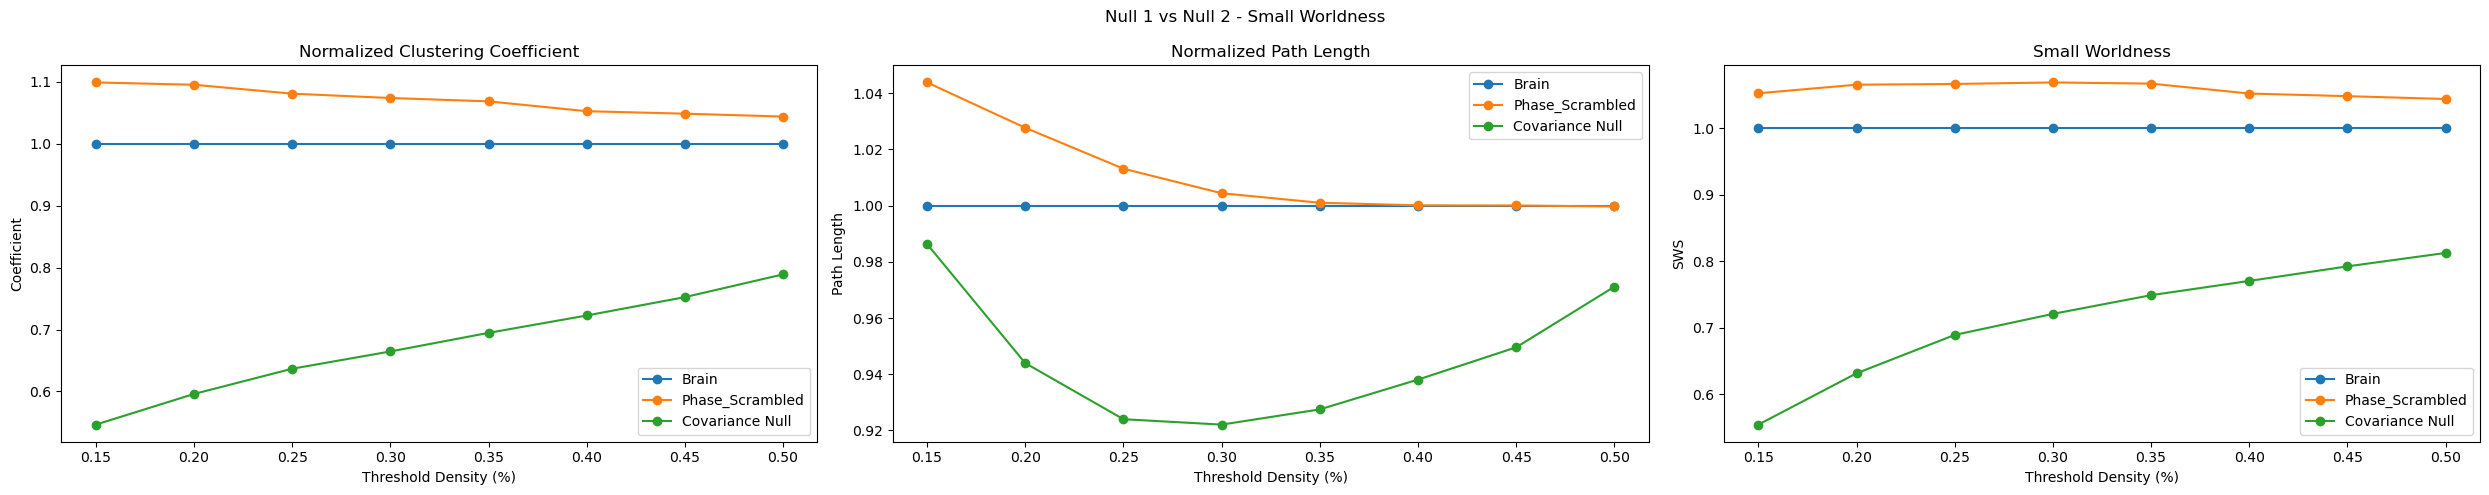

In [14]:
#getting the small worldness ratio for phase scrambled null and correlation matrix null and plotting it
def null_covariance_model(brain_corr, roi_ts, sd):
    return null_covariance(brain_corr, sd)

null2_results = run_small_worldness_analysis(
    roi_path=file_path,
    iterations=1,
    null_models=[ null_phase_scrambled, null_covariance_model],
    null_labels=["Phase_Scrambled", "Covariance Null"],
    include_brain=True,
    plot_title="Null 1 vs Null 2 - Small Worldness",
)

/Users/nivaranavat/miniconda/envs/brain-env/lib/python3.10/site-packages/pandas/core/internals/managers.py:1688: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(blk.values, dtype=dtype, copy=copy)
/Users/nivaranavat/miniconda/envs/brain-env/lib/python3.10/site-packages/pandas/core/internals/managers.py:1688: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(blk.values, dtype=dtype, copy=copy)
/Users/nivaranavat/miniconda/envs/brain-env/lib/python3.10/site-packages/pandas/core/internals/managers.py:1688: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(blk.values, dtype=dtype, copy=copy)
/Users/nivaranavat/miniconda/envs/brain-env/lib/python3.10/site-packages/pandas/core/internals/managers.py:1688: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(blk.values, dtype=dtype, copy=copy)
/Users/nivaranavat/miniconda/envs/br

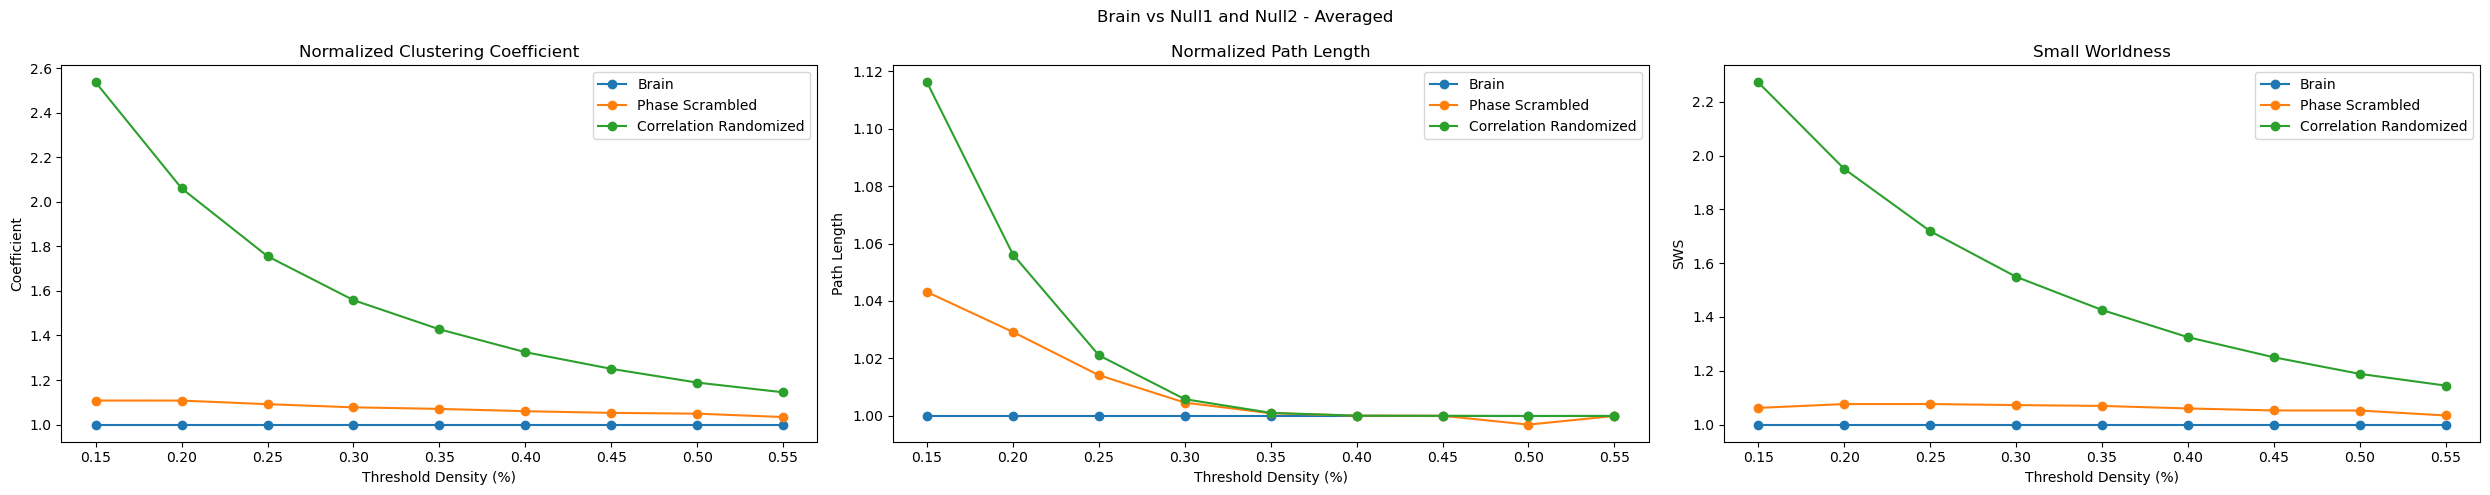

In [15]:
#average it out for some iterations to normalize the randomness
#while also having a threshold density from 5% to 50%

def null_correlation_randomized(brain_corr, roi_ts, sd):
    # Randomize the correlation matrix using your util
    return randomizeCorrelationMatrix(brain_corr, sd)

# Now run the analysis with both nulls
results = run_small_worldness_analysis(
    roi_path=file_path,
    iterations=25,
    threshold_end=0.60,
    null_models=[null_phase_scrambled, null_correlation_randomized],
    null_labels=["Phase Scrambled", "Correlation Randomized"],
    include_brain=True,
    plot_title="Brain vs Null1 and Null2 - Averaged",
)

/Users/nivaranavat/miniconda/envs/brain-env/lib/python3.10/statistics.py:428: RuntimeWarning: divide by zero encountered in double_scalars
  T, total, count = _sum(w / x if w else 0 for w, x in zip(weights, data))
/Users/nivaranavat/BrainConnectivity_ResearchProject/source/phase_and_correlation_scramble.py:97: RuntimeWarning: divide by zero encountered in double_scalars
  ccoef_ratio = observed_ccoef/randomized_ccoef


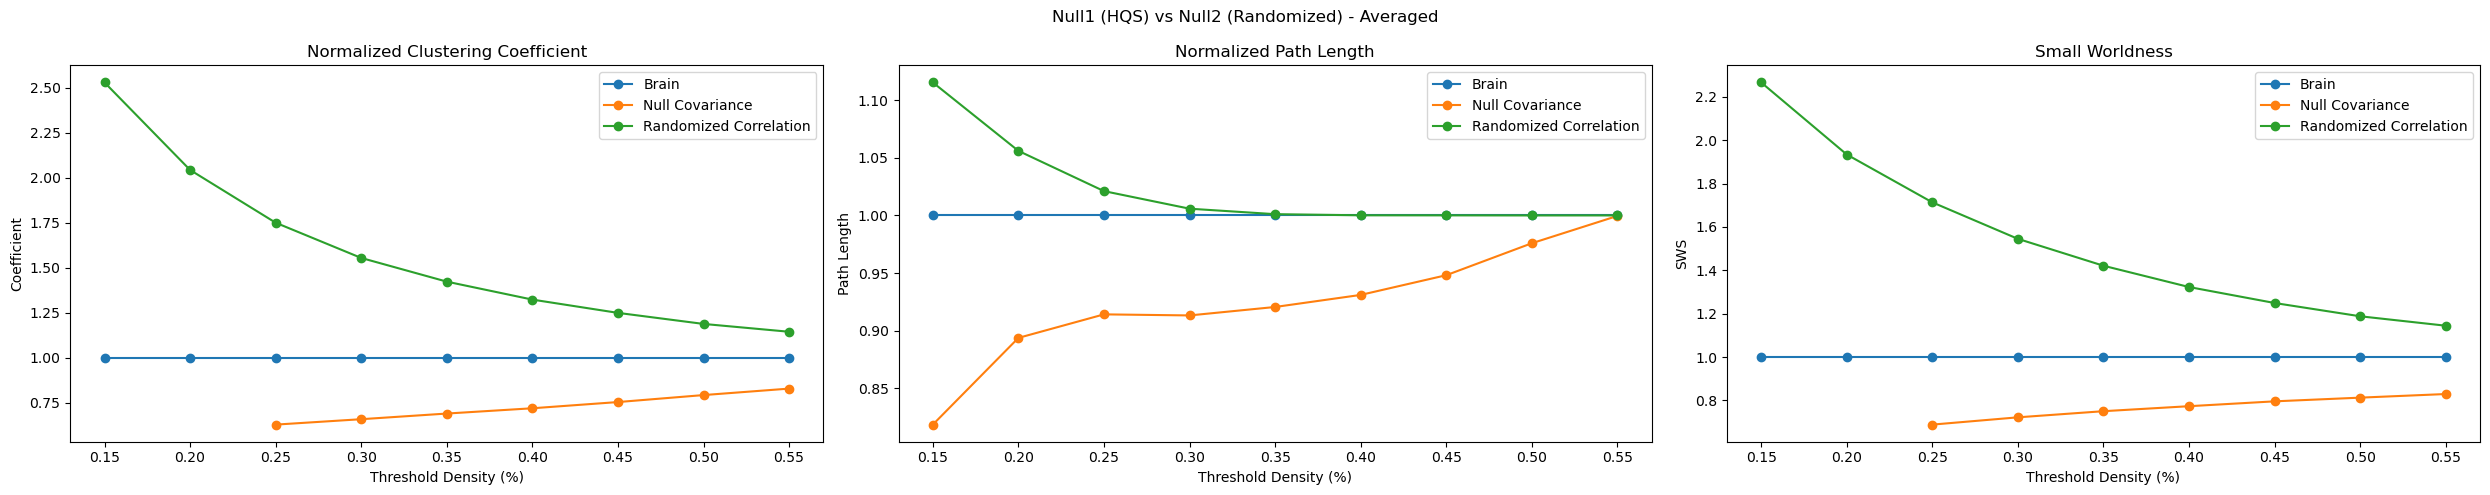

{'Brain': {'sws': array([1., 1., 1., 1., 1., 1., 1., 1., 1.]),
  'ccoef': array([1., 1., 1., 1., 1., 1., 1., 1., 1.]),
  'path': array([1., 1., 1., 1., 1., 1., 1., 1., 1.])},
 'Null Covariance': {'sws': array([       inf,        inf, 0.68835763, 0.72195065, 0.75025538,
         0.77330348, 0.79568663, 0.81275464, 0.8294016 ]),
  'ccoef': array([       inf,        inf, 0.62917261, 0.65922821, 0.6905842 ,
         0.71991156, 0.75438233, 0.79313391, 0.8290539 ]),
  'path': array([0.81834441, 0.89365605, 0.91408347, 0.91315578, 0.92049877,
         0.93097436, 0.94809589, 0.97585942, 0.99957324])},
 'Randomized Correlation': {'sws': array([2.26658871, 1.9341893 , 1.71357069, 1.54515354, 1.42113836,
         1.32291308, 1.24925832, 1.1880418 , 1.14454404]),
  'ccoef': array([2.5283584 , 2.04260597, 1.749746  , 1.55418584, 1.42268817,
         1.32305538, 1.24933636, 1.18803754, 1.14456097]),
  'path': array([1.11548146, 1.05605213, 1.02111112, 1.00584556, 1.00109054,
         1.00010756, 1

In [16]:
#average it out for some iterations to normalize the randomness
#while also having a threshold density from 5% to 50%

run_small_worldness_analysis(
    roi_path=file_path,
    iterations=25,
    threshold_end=0.60,
    null_models=[null_covariance_model, null_correlation_randomized],
    null_labels=["Null Covariance", "Randomized Correlation"],
    include_brain=True,
    plot_title="Null1 (HQS) vs Null2 (Randomized) - Averaged",
)